In [1]:
# importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteScaledError, MeanSquaredScaledError
from math import sqrt, ceil, floor

In [2]:
# Leer train y test
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [3]:
train['idSecuencia'] = pd.to_datetime(train['idSecuencia'])
test['idSecuencia'] = pd.to_datetime(test['idSecuencia'])

In [4]:
train_mean = train.groupby(['idSku'])['udsVenta'].mean().reset_index()
train_mean.rename(columns={'udsVenta': 'mean'}, inplace=True)
train_mean['mean'] = train_mean['mean'].apply(lambda x: round(x))

train_mean

,idSku,mean
0,1,14
1,2,17
2,3,10
3,4,9
4,5,11
5,6,10
6,7,9
7,8,6
8,9,6
9,10,6


In [6]:
test = test[['idSku', 'idSecuencia', 'bolHoliday', 'udsVenta']]
test = pd.merge(test, train_mean, on='idSku', how='left')
test.rename(columns={'mean': 'udsVenta_pred'}, inplace=True)
test.head()

,idSku,idSecuencia,bolHoliday,udsVenta,udsVenta_pred
0,1,2021-11-07,1,0,14
1,1,2021-11-08,0,27,14
2,1,2021-11-09,0,9,14
3,1,2021-11-10,0,0,14
4,1,2021-11-11,0,9,14


In [7]:
# importar ../Data/DatosCicloAprovisionamiento.xlsx
df_ciclo = pd.read_excel('../Data/DatosCicloAprovisionamiento.xlsx')
df_ciclo = df_ciclo.sort_values(by=['sku']).reset_index(drop=True)
df_ciclo = df_ciclo.rename(columns={'sku': 'idSku'})
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime
0,1,18,2
1,2,28,4
2,3,28,2
3,4,14,2
4,5,14,4


In [8]:
# create a column named ciclo_aprovisionamiento with sum of diasEntrePedidos and diasLeadtime
df_ciclo['ciclo_aprovisionamiento'] = df_ciclo['diasEntrePedidos'] + df_ciclo['diasLeadtime']
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento
0,1,18,2,20
1,2,28,4,32
2,3,28,2,30
3,4,14,2,16
4,5,14,4,18


In [9]:
results = pd.DataFrame(columns=['idSku', 'target', 'prediction'])
# iterate over each sku of df_ciclo
for i in range(len(df_ciclo)):

    # get the sku
    sku = df_ciclo.loc[i, 'idSku']

    # get the ciclo_aprovisionamiento
    ciclo_aprovisionamiento = df_ciclo.loc[i, 'ciclo_aprovisionamiento']

    # create a dataframe with the idSku = sku
    df_sku = test[test['idSku'] == sku]
    # create a column with the sum of udsVenta_pred for de last ciclo_aprovisionamiento days
    df_sku['udsVenta_pred_sum'] = df_sku['udsVenta_pred'].rolling(ciclo_aprovisionamiento).sum()
    df_sku['udsVenta_sum'] = df_sku['udsVenta'].rolling(ciclo_aprovisionamiento).sum()
    df_sku.dropna(inplace=True)
    prediction = df_sku['udsVenta_pred_sum'].tolist()
    target= df_sku['udsVenta_sum'].tolist()

    # create a list with idSku, target and prediction
    r = pd.DataFrame([sku, target, prediction]).T
    r.columns = ['idSku', 'target', 'prediction']
    results = results.append(r, ignore_index=True)

C:\Users\96gar\AppData\Local\Temp\ipykernel_2172\105862565.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sku['udsVenta_pred_sum'] = df_sku['udsVenta_pred'].rolling(ciclo_aprovisionamiento).sum()
C:\Users\96gar\AppData\Local\Temp\ipykernel_2172\105862565.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sku['udsVenta_sum'] = df_sku['udsVenta'].rolling(ciclo_aprovisionamiento).sum()
C:\Users\96gar\AppData\Local\Temp\ipykernel_2172\105862565.py:16: SettingWithCopyWarning: 
A value is trying to 

In [10]:
results

,idSku,target,prediction
0,1,"[264.0, 276.0, 249.0, 252.0, 261.0, 273.0, 291...","[280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280..."
1,2,"[486.0, 495.0, 486.0, 507.0, 495.0, 498.0, 507...","[544.0, 544.0, 544.0, 544.0, 544.0, 544.0, 544..."
2,3,"[246.0, 264.0, 255.0, 254.0, 269.0, 260.0, 248...","[300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300..."
3,4,"[105.0, 114.0, 123.0, 123.0, 123.0, 117.0, 99....","[144.0, 144.0, 144.0, 144.0, 144.0, 144.0, 144..."
4,5,"[33.0, 42.0, 42.0, 51.0, 51.0, 72.0, 90.0, 102...","[198.0, 198.0, 198.0, 198.0, 198.0, 198.0, 198..."
5,6,"[69.0, 84.0, 75.0, 78.0, 99.0, 114.0, 132.0, 1...","[130.0, 130.0, 130.0, 130.0, 130.0, 130.0, 130..."
6,7,"[183.0, 195.0, 189.0, 177.0, 174.0, 174.0, 162...","[270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270..."
7,8,"[62.0, 77.0, 79.0, 71.0, 65.0, 60.0, 56.0, 51....","[72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72...."
8,9,"[96.0, 108.0, 114.0, 132.0, 126.0, 116.0, 110....","[54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54...."
9,10,"[82.0, 91.0, 90.0, 81.0, 69.0, 72.0, 75.0, 67....","[66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66...."


In [11]:
# RMSE: Root Mean Squared Error
# MAPE: Mean Absolute Percentage Error
# MASE: Mean Absolute Scaled Error
# SMAPE: Symmetric Mean Absolute Percentage Error
# RMSSE: Root Mean Squared Scaled Error

results['RMSE'] = np.nan
results['MAPE'] = np.nan
results['MASE'] = np.nan
results['SMAPE'] = np.nan
results['RMSSE'] = np.nan

rmse = MeanSquaredError(square_root=True)
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()
smape = MeanAbsolutePercentageError(symmetric=True)
rmsse = MeanSquaredScaledError(square_root=True)

# calculate rmse for each sku and append to results dataframe
for i in range(0, 50):
    t = pd.Series(results['target'][i])
    p = pd.Series(results['prediction'][i])
    y_train = train[train['idSku'] == i+1]['udsVenta']
    results['RMSE'][i] = rmse(t, p)
    results['MAPE'][i] = mape(t, p)
    results['MASE'][i] = mase(t, p, y_train=y_train)
    results['SMAPE'][i] = smape(t, p)
    results['RMSSE'][i] = rmsse(t, p, y_train=y_train)
results

C:\Users\96gar\AppData\Local\Temp\ipykernel_2172\2379025414.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['RMSE'][i] = rmse(t, p)
C:\Users\96gar\AppData\Local\Temp\ipykernel_2172\2379025414.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['MAPE'][i] = mape(t, p)
C:\Users\96gar\AppData\Local\Temp\ipykernel_2172\2379025414.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['MASE'][i] = mase(t, p, y_tr

,idSku,target,prediction,RMSE,MAPE,MASE,SMAPE,RMSSE
0,1,"[264.0, 276.0, 249.0, 252.0, 261.0, 273.0, 291...","[280.0, 280.0, 280.0, 280.0, 280.0, 280.0, 280...",38.807807,8.942551e-02,2.552545,0.095896,2.684278
1,2,"[486.0, 495.0, 486.0, 507.0, 495.0, 498.0, 507...","[544.0, 544.0, 544.0, 544.0, 544.0, 544.0, 544...",87.441527,1.668526e-01,5.418226,0.147747,5.068657
2,3,"[246.0, 264.0, 255.0, 254.0, 269.0, 260.0, 248...","[300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300...",49.175526,1.879809e-01,5.242573,0.169112,4.299076
3,4,"[105.0, 114.0, 123.0, 123.0, 123.0, 117.0, 99....","[144.0, 144.0, 144.0, 144.0, 144.0, 144.0, 144...",34.903153,2.973004e-01,3.831560,0.246704,3.371172
4,5,"[33.0, 42.0, 42.0, 51.0, 51.0, 72.0, 90.0, 102...","[198.0, 198.0, 198.0, 198.0, 198.0, 198.0, 198...",47.410228,3.138286e-01,3.413525,0.190798,3.744716
5,6,"[69.0, 84.0, 75.0, 78.0, 99.0, 114.0, 132.0, 1...","[130.0, 130.0, 130.0, 130.0, 130.0, 130.0, 130...",44.872425,3.999769e-01,4.241949,0.326988,3.639044
6,7,"[183.0, 195.0, 189.0, 177.0, 174.0, 174.0, 162...","[270.0, 270.0, 270.0, 270.0, 270.0, 270.0, 270...",61.728143,2.835501e-01,8.002159,0.241764,6.771683
7,8,"[62.0, 77.0, 79.0, 71.0, 65.0, 60.0, 56.0, 51....","[72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72.0, 72....",26.355071,3.504199e-01,3.867950,0.314006,3.463123
8,9,"[96.0, 108.0, 114.0, 132.0, 126.0, 116.0, 110....","[54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54.0, 54....",58.404409,4.913053e-01,9.595983,0.661276,7.475018
9,10,"[82.0, 91.0, 90.0, 81.0, 69.0, 72.0, 75.0, 67....","[66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66.0, 66....",21.888973,4.653134e-01,3.535830,0.360097,3.046859


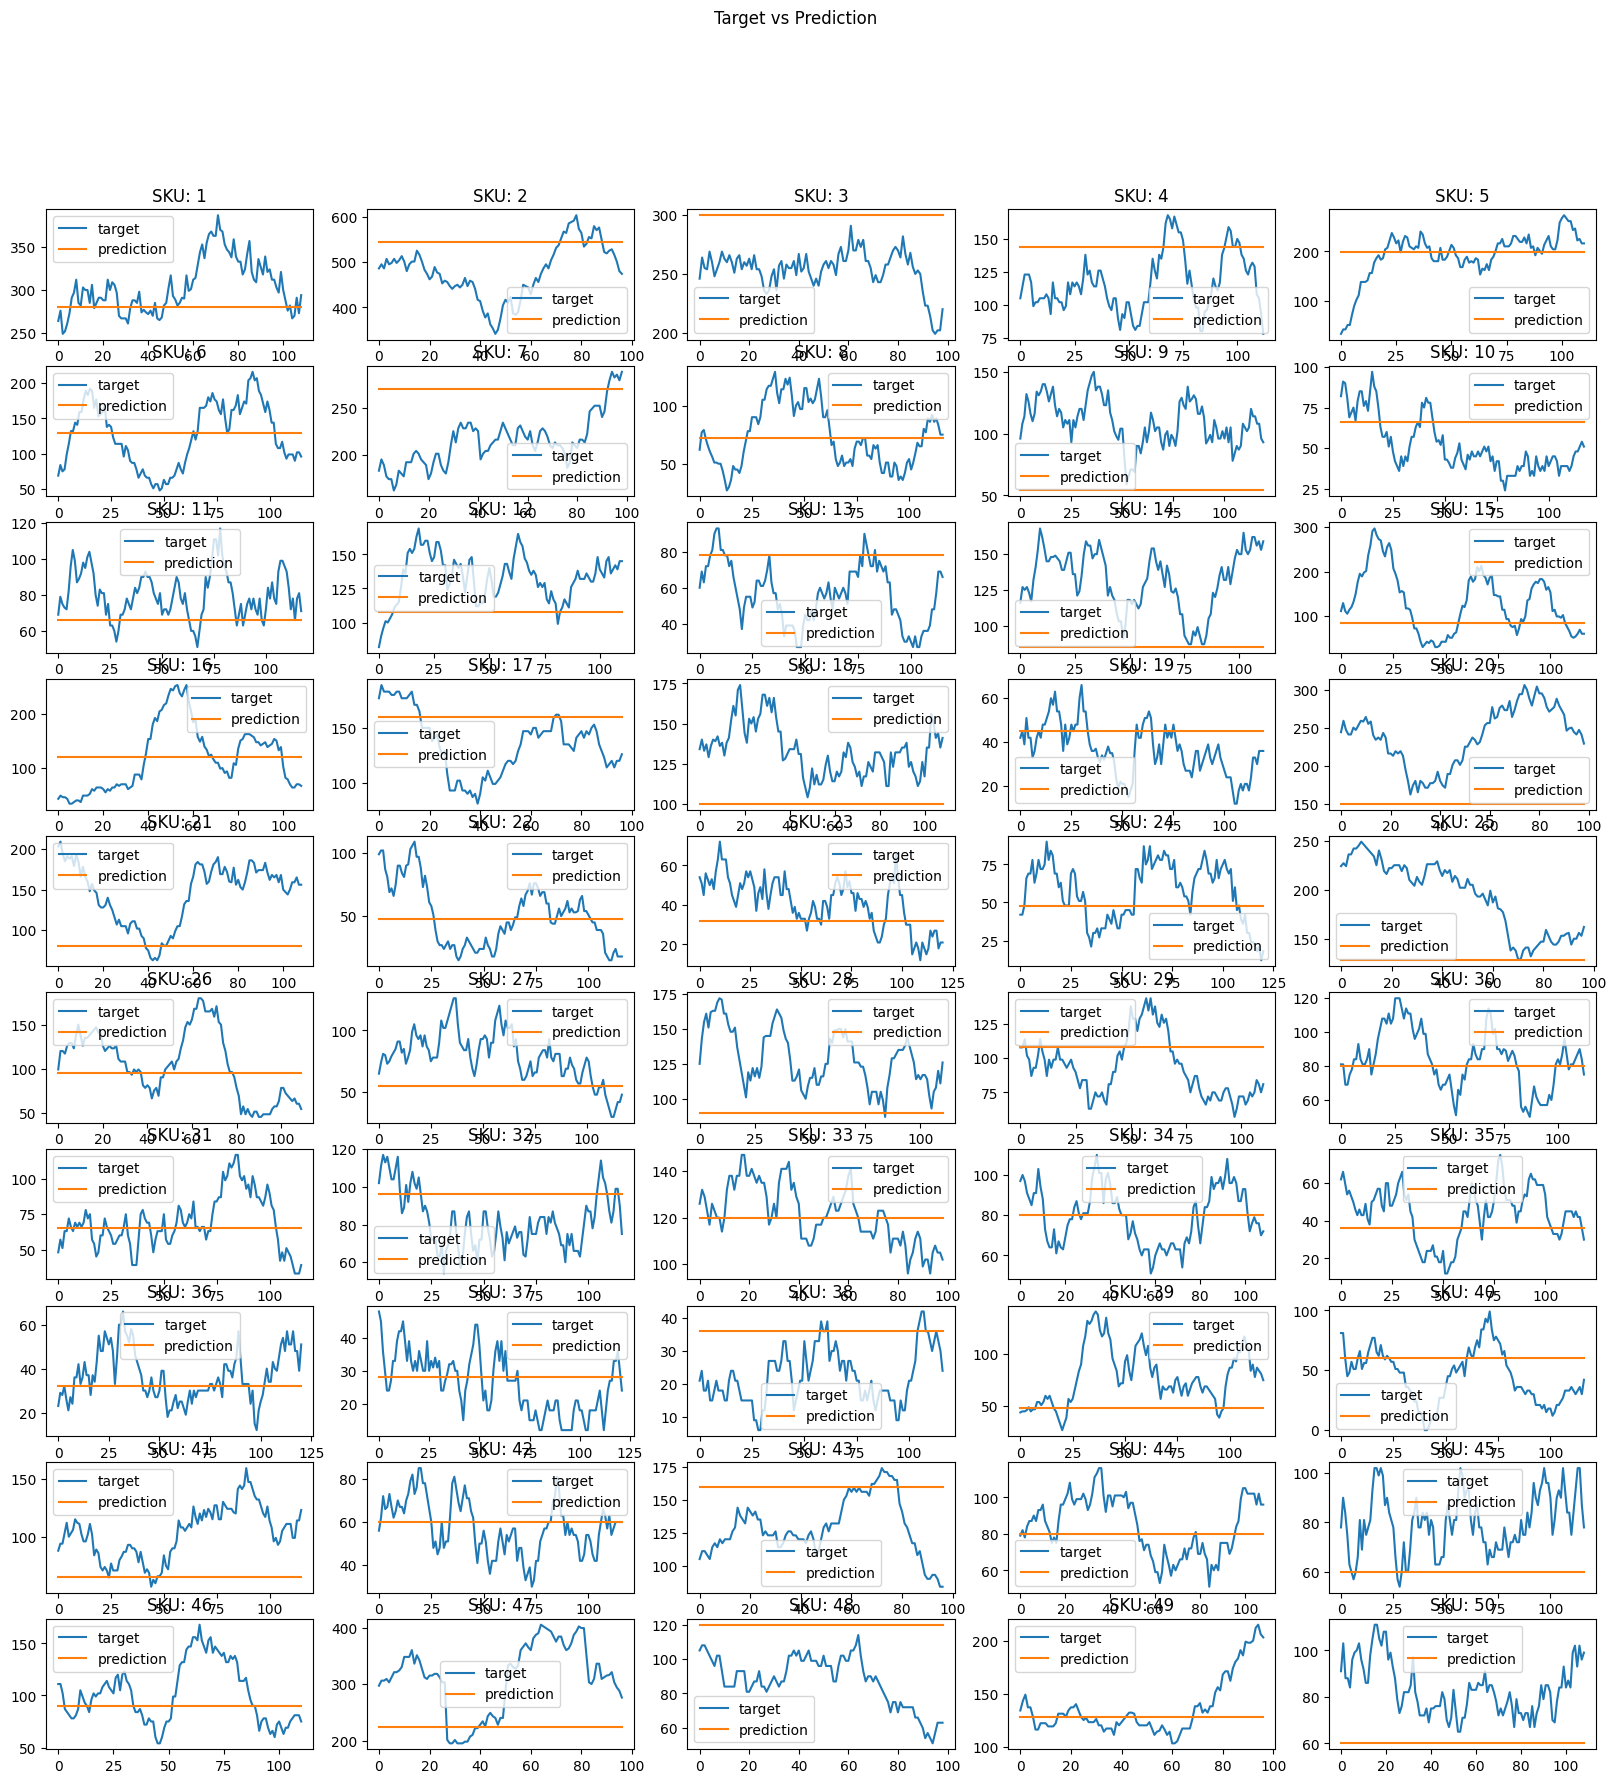

In [12]:
# make 50 subplots in a 10x5 grid and plot the target and prediction
fig, axs = plt.subplots(10, 5, figsize=(20, 20))
fig.suptitle('Target vs Prediction')
for i in range(10):
    for j in range(5):
        axs[i, j].plot(results['target'][i*5+j], label='target')
        axs[i, j].plot(results['prediction'][i*5+j], label='prediction')
        axs[i, j].legend()
        axs[i, j].set_title('SKU: ' + str(i*5+j+1))
plt.show()

In [13]:
# get the metrics of the results dataframe
metrics = results[['RMSE', 'MAPE', 'MASE', 'SMAPE', 'RMSSE']]

# get the mean of each metric
metrics_mean = metrics.mean()
metrics_mean

RMSE     3.696844e+01
MAPE     9.238153e+13
MASE     5.556174e+00
SMAPE    3.095695e-01
RMSSE    4.867036e+00
dtype: float64

In [14]:
df_precio = pd.read_excel('../Data/DatosPrecioMedio.xlsx')
df_precio = df_precio.rename(columns={'idSkuIta': 'idSku'})
df_precio = df_precio.sort_values(by=['idSku']).reset_index(drop=True)
df_precio.head()

,idSku,eurPrecioMedio
0,1,1.370002
1,2,1.370002
2,3,1.370002
3,4,1.370002
4,5,1.370002


In [15]:
df_ciclo = df_ciclo.merge(df_precio, on='idSku', how='inner')
df_ciclo = df_ciclo.merge(results[['idSku', 'RMSE']], on='idSku', how='inner')
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE
0,1,18,2,20,1.370002,38.807807
1,2,28,4,32,1.370002,87.441527
2,3,28,2,30,1.370002,49.175526
3,4,14,2,16,1.370002,34.903153
4,5,14,4,18,1.370002,47.410228


Stock de seguridad = Factor servicio *RMSE * raíz del ciclo de aprovisionamiento

In [16]:
factor = 1.64
df_ciclo['stock_seguridad'] = df_ciclo.apply(lambda x: ceil(factor * x['RMSE'] * sqrt(x['ciclo_aprovisionamiento'])), axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad
0,1,18,2,20,1.370002,38.807807,285
1,2,28,4,32,1.370002,87.441527,812
2,3,28,2,30,1.370002,49.175526,442
3,4,14,2,16,1.370002,34.903153,229
4,5,14,4,18,1.370002,47.410228,330


In [17]:
df_ciclo['coste_stock_diario'] = df_ciclo.apply(lambda x: 0.05 * x['eurPrecioMedio'] * x['stock_seguridad'], axis=1)
df_ciclo.head()

,idSku,diasEntrePedidos,diasLeadtime,ciclo_aprovisionamiento,eurPrecioMedio,RMSE,stock_seguridad,coste_stock_diario
0,1,18,2,20,1.370002,38.807807,285,19.522522
1,2,28,4,32,1.370002,87.441527,812,55.622064
2,3,28,2,30,1.370002,49.175526,442,30.277035
3,4,14,2,16,1.370002,34.903153,229,15.686518
4,5,14,4,18,1.370002,47.410228,330,22.605026


In [18]:
coste_stock_diario_total = df_ciclo['coste_stock_diario'].sum().round(2)
coste_stock_diario_anual = coste_stock_diario_total * 365

print('Coste stock total diario: {}€'.format(coste_stock_diario_total))
print('Coste stock total anual: {}€'.format(coste_stock_diario_anual))

Coste stock total diario: 2323.38€
Coste stock total anual: 848033.7000000001€
